In [1]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.base import clone
from rfpimp import *
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [3]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=20, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
#             oob_score=False, random_state=None, verbose=0,
#             warm_start=False)

In [4]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='red')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [5]:
# X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
# y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')

y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
# X_train.fillna(value = 0, inplace = True)
# X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)

In [6]:
    predictions = rf_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions)
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

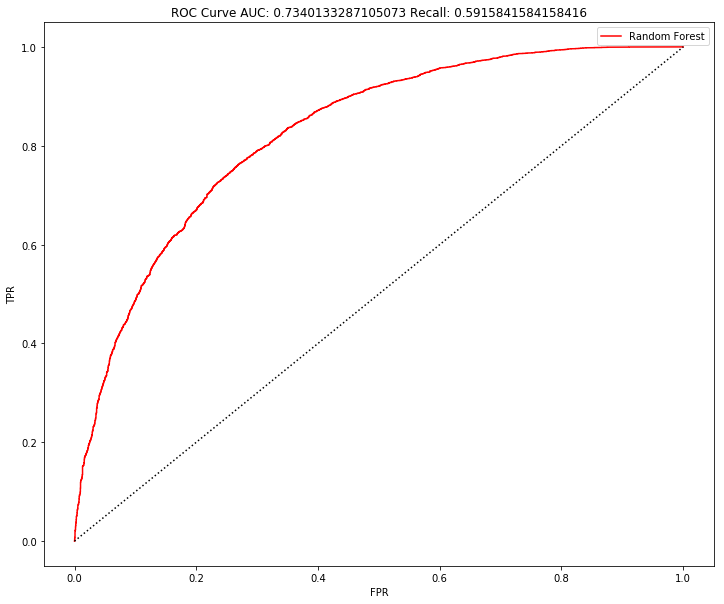

Best Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Roc Auc: 0.7340133287105073

Recall Score: 0.5915841584158416

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix:
 [[2151  621]
 [1485 4405]]


In [7]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(rf_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [8]:
feat_imp = importances(rf_model, X_test, y_test)

In [9]:
feat_imp.sort_values(by='Importance', ascending=False)[0:10]

,Importance
Feature,
avg_score,0.0580
sum_days_vle_accessed,0.0088
sum_click_page,0.0088
highest_education_Lower Than A Level,0.0072
days_early_first_assessment,0.0070
code_module_GGG,0.0068
avg_days_sub_early,0.0058
code_module_FFF,0.0040
sum_click_subpage,0.0034


In [10]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[300:1000:25]

,fprs,tprs,Thresholds
300,0.046480,0.315559,0.815602
325,0.050330,0.330283,0.811187
350,0.054180,0.343613,0.807390
375,0.057756,0.364704,0.800019
400,0.062156,0.383804,0.793681
425,0.066557,0.395941,0.788941
450,0.070957,0.412654,0.782486
475,0.075358,0.423000,0.778343
500,0.079483,0.433148,0.774610
525,0.085259,0.444091,0.769988
